# Causal Inference

In this notebook, we will use Python package CausalML to estimate Conditional Average Treatment Effect (CATE) for some variables in our data

"Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form."

In his notebook ['INSY_695_Model_Development_Selection_CrossValidation.ipynb'](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/blob/DataScientist/INSY_695_Model_Development_Selection_CrossValidation.ipynb), my teammate Raman Vakil found that an extra tree regressor was the most accurate model for estimating the cost of aquiring a customer, so we will move forward with an extra tree model as our base algorithm in our Meta-Learner algorithm.

### [Business Use Cases to Keep in mind](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/tree/BusinessAnalyst)
**Profit:** the idea here is to look at the ratio (Revenue-Cost)/Revenue, it would be interesting to understand what factors increase or decrease this ratio. If some types of stores are more profitable than others, that also mean the stores in question can reinvest more in their business in the opposite of other that may lose money.


**Loyalty:** We have a loyalty feature based on different categories (normal, bronze, silver, or gold). The idea is to “measure loyalty”.



In [1]:
import pandas as pd

from sklearn.ensemble import ExtraTreesRegressor
from causalml.inference.meta import BaseSRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing 


/Users/bennettfahey/opt/anaconda3/envs/quant/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Input data in this notebook is the output of my teammate Chongho Pyo's [preprocessing notebook: ](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/blob/main/Preprocessing%20(v0.0).ipynb) Data will be modified however with label feature encoding, as opposed to one-hot encoding, this will allow for easier interpretation of treatment variables.

In [2]:
df_og = pd.read_csv("/Users/bennettfahey/Desktop/Enterprise 1/Group Project/causal_inf_input.csv")
df = df_og.copy()

### Feature engineering as it relates to our business use cases

In [3]:
df['profit_margin'] = (df['store_sales(in millions)'] - df['store_cost(in millions)']) / df['store_sales(in millions)']
corr_matrix = df.corr()
corr_matrix["cost"].sort_values(ascending=False)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


cost                          1.000000
avg_cars_at home(approx)      0.011363
avg_cars_at home(approx).1    0.011363
low_fat                       0.003686
SRP                           0.003002
net_weight                    0.000344
gross_weight                  0.000034
num_children_at_home         -0.001789
recyclable_package           -0.002495
total_children               -0.003141
units_per_case               -0.003508
store_cost(in millions)      -0.005024
profit_margin                -0.005076
store_sales(in millions)     -0.005791
unit_sales(in millions)      -0.019047
grocery_sqft                 -0.026696
store_sqft                   -0.046218
meat_sqft                    -0.059907
frozen_sqft                  -0.059922
coffee_bar                   -0.082083
florist                      -0.112033
salad_bar                    -0.113588
prepared_food                -0.113588
video_store                  -0.123732
Name: cost, dtype: float64

Observed here sales (revenue) is positively correlated with profit margin and cost is negatively correlated.

In [4]:
df

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,avg_cars_at home(approx).1,SRP,gross_weight,net_weight,...,media_type,recyclable_package,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,profit_margin
0,-0.388666,-0.464620,0.2,-0.6,-0.5,-0.6,-0.5,-0.229885,0.723270,0.650704,...,"Daily Paper, Radio",1.0,0.0,1.0,1.0,1.0,1.0,1.0,126.62,-0.195423
1,-0.552878,-0.491556,-0.2,-1.0,1.0,-1.0,1.0,-0.229885,0.723270,0.650704,...,"Daily Paper, Radio",1.0,0.0,1.0,1.0,1.0,1.0,1.0,59.86,0.110914
2,-0.717091,-0.749375,-0.6,0.6,-0.5,-1.0,-0.5,-0.229885,0.723270,0.650704,...,"Daily Paper, Radio",1.0,0.0,1.0,1.0,1.0,1.0,1.0,84.16,-0.045022
3,-0.717091,-0.787856,-0.6,-0.2,0.0,-0.2,0.0,-0.229885,0.723270,0.650704,...,In-Store Coupon,1.0,0.0,1.0,1.0,1.0,1.0,1.0,95.78,-0.098684
4,-0.560018,-0.499420,0.2,0.6,0.0,-1.0,0.0,-0.505747,-0.859119,-0.767887,...,In-Store Coupon,0.0,1.0,1.0,1.0,1.0,1.0,1.0,95.78,0.108208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57418,-0.799197,-0.757071,-1.0,-0.6,-0.5,-0.6,-0.5,0.298851,0.710692,0.752113,...,In-Store Coupon,1.0,0.0,1.0,0.0,0.0,0.0,0.0,95.25,0.052710
57419,-0.902722,-0.930401,-1.0,-0.2,0.0,-1.0,0.0,-0.367816,0.433962,0.380282,...,Sunday Paper,1.0,0.0,1.0,0.0,0.0,0.0,0.0,69.42,-0.030661
57420,-0.552878,-0.503100,-0.6,-0.6,0.5,-1.0,0.5,0.298851,0.710692,0.752113,...,"Sunday Paper, Radio, TV",1.0,0.0,1.0,0.0,0.0,0.0,0.0,67.51,0.090034
57421,-0.306560,-0.497328,-0.2,-0.2,1.0,-1.0,1.0,0.298851,0.710692,0.752113,...,Sunday Paper,1.0,0.0,1.0,0.0,0.0,0.0,1.0,132.88,-0.622289


In [5]:
#Ordinal encode Member_Card

mapping = {'Normal': 0, 'Bronze': 1, 'Silver': 2, 'Golden': 3}

df['member_card'] = df['member_card'].map(mapping)


#One-Hot Encode Media_type
one_hot = pd.get_dummies(df['media_type'])

df = pd.concat([df, one_hot], axis=1)



#Label encode the rest of categorical

label_encoder = preprocessing.LabelEncoder() 

for column in df.columns:
    if df[column].dtype == 'object': 
        df[column] = label_encoder.fit_transform(df[column].tolist()) 
        


# UC1: Effect of Gender on Cost of aquisition

In [6]:
#Gender on cost
#Something on ratio
#loyalty

df2 = df.copy()
y = df2["cost"]
W = df2[["gender"]]
W = np.array(W)
X = df2.drop(columns = ["cost"])

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [7]:
features = X.columns
features

Index(['store_sales(in millions)', 'store_cost(in millions)',
       'unit_sales(in millions)', 'total_children', 'avg_cars_at home(approx)',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'SRP',
       'gross_weight', 'net_weight', 'units_per_case', 'store_sqft',
       'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'food_category',
       'food_department', 'food_family', 'promotion_name', 'sales_country',
       'marital_status', 'gender', 'education', 'member_card', 'occupation',
       'houseowner', 'avg. yearly_income', 'brand_name', 'store_type',
       'store_city', 'store_state', 'media_type', 'recyclable_package',
       'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'profit_margin', 'Bulk Mail', 'Cash Register Handout',
       'Daily Paper', 'Daily Paper, Radio', 'Daily Paper, Radio, TV',
       'In-Store Coupon', 'Product Attachment', 'Radio', 'Street Handout',
       'Sunday Paper', 'Sunday Paper, Radio', 'Sunday Paper, R

In [8]:
base_algo = ExtraTreesRegressor()

In [9]:
slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

{'treatment_A': promotion_name                0.150038
 total_children                0.059672
 gender                        0.058870
 occupation                    0.055630
 education                     0.053539
 avg. yearly_income            0.048404
 houseowner                    0.046865
 num_children_at_home          0.044999
 avg_cars_at home(approx).1    0.040658
 marital_status                0.039051
 store_city                    0.037302
 avg_cars_at home(approx)      0.036452
 member_card                   0.032178
 store_state                   0.026541
 Cash Register Handout         0.023084
 coffee_bar                    0.021582
 unit_sales(in millions)       0.019839
 grocery_sqft                  0.019194
 store_sqft                    0.018120
 meat_sqft                     0.017048
 frozen_sqft                   0.016498
 Daily Paper                   0.013098
 florist                       0.011899
 store_type                    0.008638
 Product Attachment      

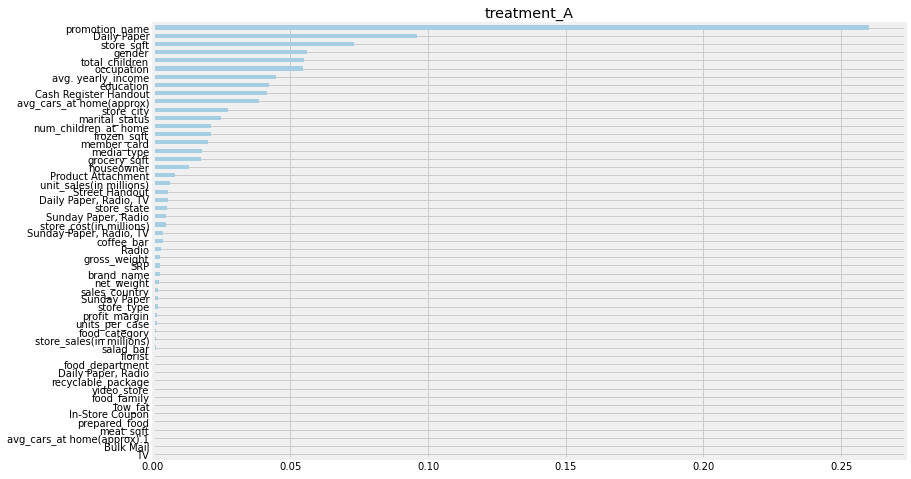

In [10]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=features)

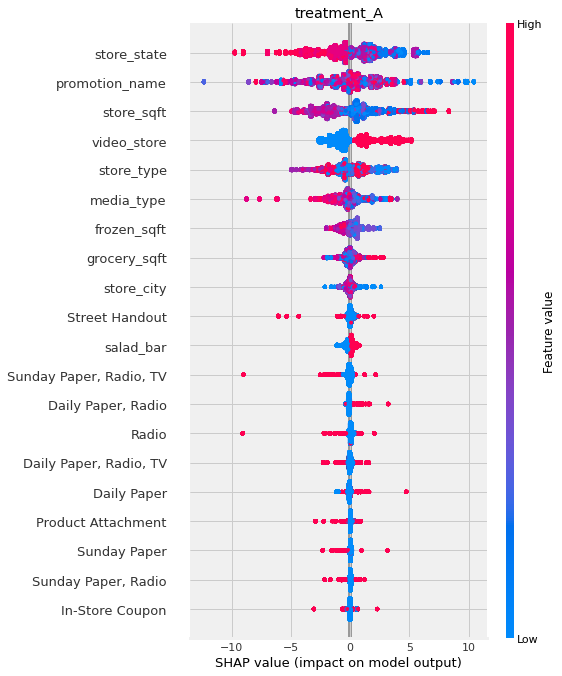

In [21]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)


# UC2: Member card (ordinal encoded) status on cost

In [12]:
df2 = df.copy()
y = df2["cost"]
W = df2[["member_card"]]
W = np.array(W)
X = df2.drop(columns = [ "cost"])

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [13]:
base_algo = ExtraTreesRegressor()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

{'treatment_A': promotion_name                0.211275
 occupation                    0.062472
 education                     0.058195
 total_children                0.057325
 member_card                   0.056523
 avg. yearly_income            0.052257
 gender                        0.048212
 avg_cars_at home(approx)      0.047255
 avg_cars_at home(approx).1    0.044603
 num_children_at_home          0.031425
 houseowner                    0.031136
 marital_status                0.028328
 Daily Paper, Radio            0.017170
 store_city                    0.017023
 frozen_sqft                   0.016535
 store_state                   0.016385
 meat_sqft                     0.016322
 Cash Register Handout         0.016149
 store_sqft                    0.014008
 Product Attachment            0.013468
 grocery_sqft                  0.011755
 unit_sales(in millions)       0.010081
 Daily Paper                   0.008594
 store_type                    0.008149
 coffee_bar              

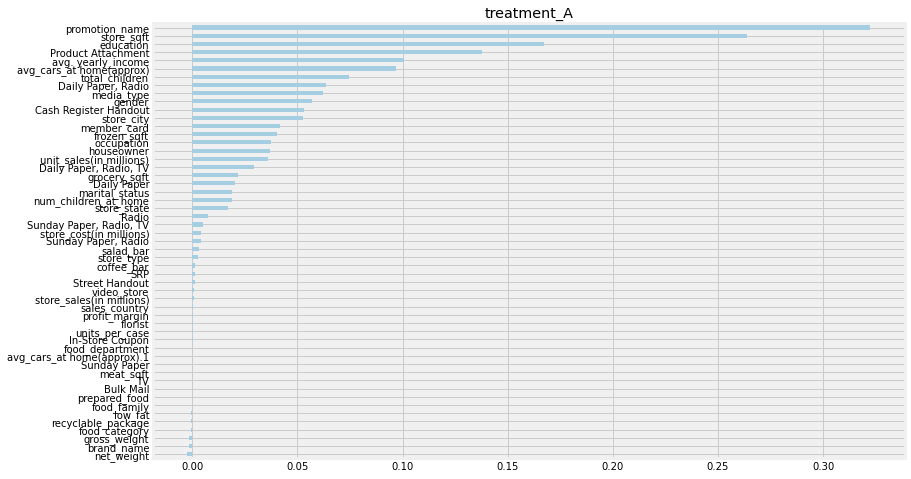

In [14]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='permutation', #auto
                         features=features)

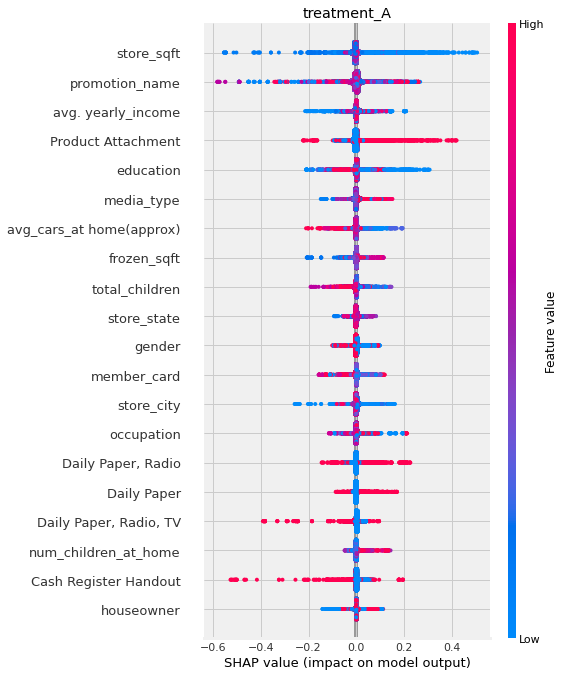

In [15]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)

# UC3: Media type (one-hot encoded) effect on cost

In [16]:
y = df2["cost"]
W = df2[["media_type"]]
W = np.array(W)
X = df2.drop(columns = ["cost"]) #dummify

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [17]:
base_algo = ExtraTreesRegressor()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

{'treatment_A': promotion_name                0.212895
 video_store                   0.121277
 store_state                   0.075892
 Radio                         0.048716
 store_type                    0.038768
 sales_country                 0.036998
 grocery_sqft                  0.035639
 Street Handout                0.035299
 Sunday Paper, Radio, TV       0.031810
 store_sqft                    0.030363
 frozen_sqft                   0.028673
 meat_sqft                     0.027677
 Sunday Paper                  0.026402
 media_type                    0.026258
 prepared_food                 0.025806
 Daily Paper, Radio            0.022200
 Daily Paper                   0.020196
 Daily Paper, Radio, TV        0.019501
 TV                            0.018897
 salad_bar                     0.018862
 Sunday Paper, Radio           0.018112
 store_city                    0.017483
 Product Attachment            0.012793
 In-Store Coupon               0.012682
 florist                 

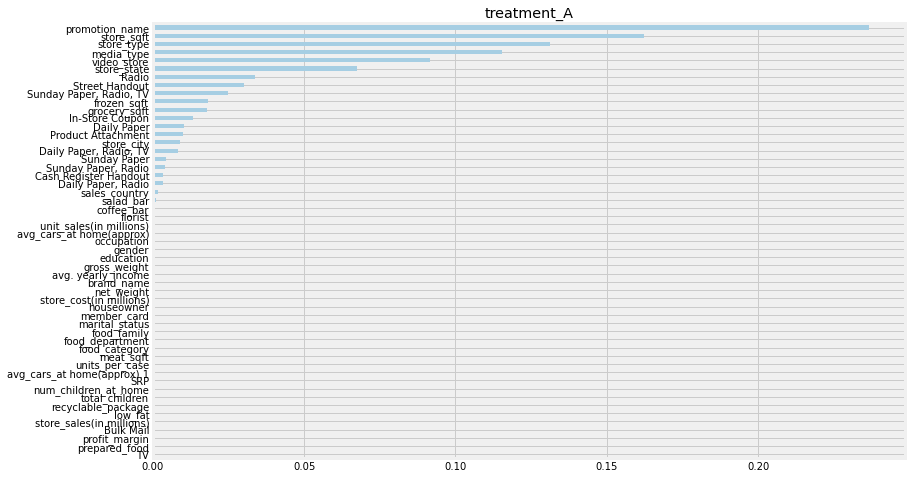

In [18]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=features)

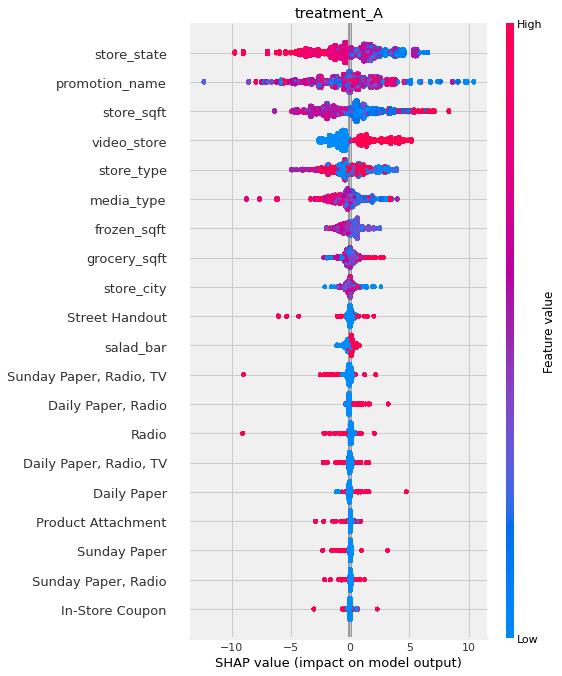

In [19]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)